In [1]:
from gensim.models import word2vec,Word2Vec
from gensim.utils import tokenize
import pandas as pd
import numpy as np
import pandas as pd
import re
from nltk.tokenize import sent_tokenize
from gensim.models.phrases import Phrases, Phraser
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [2]:
data = pd.read_csv("data_clean.csv")

In [3]:
data.head()

,text,label
0,alway wrote seri complet stinkfest jim belushi...,0
1,1st watch 10dirstev purcel typic mari kate ash...,0
2,movi poorli written direct fell asleep minut m...,0
3,interest thing miryang secret sunshin actor je...,1
4,first read berlin meer didnt expect much thoug...,0


In [4]:
data.label.value_counts()

1    24884
0    24698
Name: label, dtype: int64

In [5]:
data = data.dropna()

In [6]:
def preprocess_label(review):
    review_text = review
    words = review_text.split()
    return (words)
def labels_to_sentences(label):
    raw_sentences = sent_tokenize(label.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence)>0:
            sentences.append(preprocess_label(raw_sentence))
    return sentences

In [7]:
labels_to_sentences(data['text'][0])

[['alway',
  'wrote',
  'seri',
  'complet',
  'stinkfest',
  'jim',
  'belushi',
  'involv',
  'heavili',
  'one',
  'day',
  'tragic',
  'happenst',
  'occur',
  'white',
  'sox',
  'game',
  'end',
  'realiz',
  'remot',
  'way',
  'side',
  'room',
  'somehow',
  'could',
  'gotten',
  'walk',
  'across',
  'room',
  'get',
  'remot',
  'even',
  'tv',
  'turn',
  'channel',
  'get',
  'walk',
  'across',
  'countri',
  'watch',
  'tv',
  'anoth',
  'state',
  'nut',
  'said',
  'decid',
  'hang',
  'tight',
  'couch',
  'take',
  'whatev',
  'fate',
  'store',
  'fate',
  'store',
  'episod',
  'show',
  'episod',
  'rememb',
  'littl',
  'except',
  'made',
  'broad',
  'gener',
  'sweep',
  'blanket',
  'judgment',
  'base',
  'zero',
  'object',
  'experienti',
  'evid',
  'noth',
  'whatsoev',
  'back',
  'opinion',
  'complet',
  'right',
  'show',
  'total',
  'crudpi',
  'belushi',
  'comed',
  'deliveri',
  'hairi',
  'lighthous',
  'foghorn',
  'women',
  'physic',
  'att

In [8]:
sentences = []
for review in data["text"]:
    if type(review) == float:
        continue
    sentences += labels_to_sentences(review)
len(sentences)

49582

In [9]:
#sent = [row.split() for row in data['text'] if not type(row) == float]
#phrases = Phrases(sent, min_count=1, progress_per=10000)
#sentences = phrases[sent]

In [10]:
num_features = 300  
min_word_count = 3
num_workers = 4     
context = 10       
downsampling = 1e-3 # (0.001) 

from gensim.models import word2vec
model = word2vec.Word2Vec(sentences,\
                          workers=num_workers,\
                          size=num_features,\
                          min_count=min_word_count,\
                          window=context,
                          sample=downsampling,
                          sg = 1
                         )

model.init_sims(replace=True)

In [11]:
model.wv.vectors.shape

(42553, 300)

In [14]:
model.wv.most_similar("tv")

[('televis', 0.7729334235191345),
 ('sb', 0.6290203332901001),
 ('airedbr', 0.6105877161026001),
 ('infomerci', 0.6090489029884338),
 ('bbc1', 0.6056427955627441),
 ('primetim', 0.6036916375160217),
 ('geico', 0.5962173938751221),
 ('jpii', 0.5960251688957214),
 ('bbc2', 0.5954005122184753),
 ('channelbr', 0.5932356119155884)]

In [15]:
def featureVecMethod(words, model, num_features):
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])

    featureVec = np.divide(featureVec, nwords)
    return featureVec
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs
data_vects = []
for review in data['text']:
        data_vects.append(preprocess_label(review))
    
dataAvgVects = getAvgFeatureVecs(data_vects, model, num_features)

//anaconda3/envs/cloudcompt/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [16]:
dataVects = []
for item in dataAvgVects:
    item[np.isnan(item)] = 0
    dataVects.append(item)

In [18]:
len(dataVects)

49582

In [19]:
len(data)

49582

In [20]:
dataVects = np.asarray(dataVects)

In [21]:
encoder = LabelBinarizer()
y = encoder.fit_transform(data['label'])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(dataVects,y,test_size=0.2,random_state = 42)

In [23]:
X_train.shape

(39665, 300)

In [43]:
y_test.shape

(9917, 1)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

In [28]:
classifier = Sequential()
classifier.add(Dense(units=128,activation='relu',input_shape=(300,)))
classifier.add(Dense(units=128,activation='relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units=128,activation='relu'))
classifier.add(Dense(units=128,activation='relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units=128,activation='relu'))
classifier.add(Dense(units=128,activation='relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units=128,activation='relu'))
classifier.add(Dense(units=128,activation='relu'))

classifier.add(Dense(units=1,activation='sigmoid'))

classifier.compile(optimizer='adam',
              loss='binary_crossentropy',metrics=['accuracy'])

In [29]:
history = classifier.fit(x=X_train, 
          y=y_train, 
          epochs=30,
          validation_data=(X_test, y_test), verbose=1)

Train on 39665 samples, validate on 9917 samples
Epoch 1/30
39665/39665 [==============================] - 14s 358us/sample - loss: 0.3480 - accuracy: 0.8510 - val_loss: 0.3163 - val_accuracy: 0.8711
Epoch 2/30
39665/39665 [==============================] - 11s 269us/sample - loss: 0.3076 - accuracy: 0.8740 - val_loss: 0.2938 - val_accuracy: 0.8762
Epoch 3/30
39665/39665 [==============================] - 11s 272us/sample - loss: 0.2944 - accuracy: 0.8799 - val_loss: 0.3107 - val_accuracy: 0.8734
Epoch 4/30
39665/39665 [==============================] - 11s 277us/sample - loss: 0.2931 - accuracy: 0.8812 - val_loss: 0.2903 - val_accuracy: 0.8832
Epoch 5/30
39665/39665 [==============================] - 11s 278us/sample - loss: 0.2887 - accuracy: 0.8807 - val_loss: 0.2756 - val_accuracy: 0.8850
Epoch 6/30
39665/39665 [==============================] - 11s 282us/sample - loss: 0.2852 - accuracy: 0.8829 - val_loss: 0.2766 - val_accuracy: 0.8843
Epoch 7/30
39665/39665 [=====================

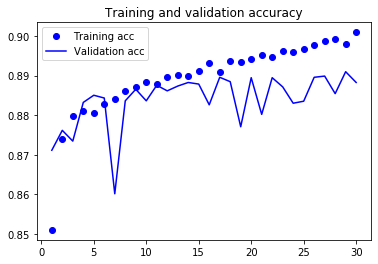

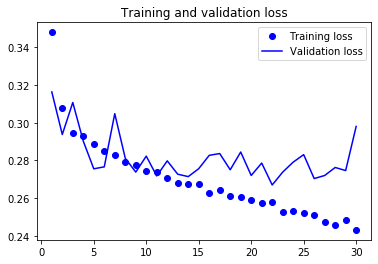

In [32]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
classifier.predict_classes(np.expand_dims(X_train[1],axis=0))[0][0]

1

In [62]:
y_train[1][]

array([1])

In [65]:
model.save("word2vec.model")

In [66]:
classifier.save("sentiment_classifier.h5")

In [5]:
model = Word2Vec.load("word2vec.model")

In [6]:
from tensorflow.keras.models import load_model
classifier = load_model("sentiment_classifier.h5")

In [19]:
data = getAvgFeatureVecs([data['text'][0]],model,300)

//anaconda3/envs/cloudcompt/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [20]:
dataVects = []
for item in data:
    item[np.isnan(item)] = 0
    dataVects.append(item)

In [23]:
classifier.predict(dataVects[0])

ValueError: Input 0 of layer sequential_30 is incompatible with the layer: expected axis -1 of input shape to have value 300 but received input with shape [None, 1]